<font size=25, color='#ED1F24'>Laboratory 5

<font size=25, color='#ED1F24'>Convolutional Neural Networks (CNNs)

**Summary:**


*   learn about convolutions 
*   learn to build Convolution Neural Networks (CNNs)
*   train CNNs
*   use pretrained models





**Motivation**

Fully Connected Layer 

<div>
<img src=https://drive.google.com/uc?id=1xaImbI9cZfaMPjc1UfG8OXymqYAl3aCN width="600"/>
</div>

---
Images
<div>
<img src=https://drive.google.com/uc?id=1MZ64Ay5PIozenvyIzN1TveNEj-ATqnLd width="600"/>
<div>

---

In order to use a fully connected layer for processing an image, we need to flatten the image ($⇒$ get a vector). The input size of our layer will be equal to the number of pixels contained in the image, multiplied by the number of channels. So, if we are working with RGB images, at a resolution of ($width$, $height$), the input size would be $3 * width * height$.

After image flattening, the input would look something like this:
<div>
<img src=https://drive.google.com/uc?id=1I5nv1Ly6EUAAZbdntYxId2o7CKD78SCa width="1000"/>
<div>

This is an undesirable approach and during this laboratory, we will explore an alternative approach.

---



**Question 1** 
If we stack multiple fully connected layers of the form $y=Wx$, can we model complex functions?

**Question 2** Do we have any limitation regarding the functions that we could model using a fully connected network (composed of multiple fully connected layers, with non-linear activations) ? 

Solution

**Answer 1** No. Stacking multiple linear layers, without non-linearities in-between, would result in a linear function.

**Answer 2** No. Fully connected networks are universal approximators.

Main drawbacks of Fully Connected Networks:

*   many parameters $⇒$ require a lot of training examples
*   each pixel is treated differently $⇒$ it has to learn redundant features
*   small image translations would induce different outputs

Insights for processing images (useful biases):

*   close neighbors of one pixel are more relevant than distant ones
*   an observed pattern should have the same meaning regardless its position in the image







Convolutional Neural Networks (CNNs) exploit the above mentioned biases and tackle the main drawbacks of Fully Connected Networks. 

<div>
<img src=https://drive.google.com/uc?id=1PtO6mNFtm71ftrn2ea0huyvEk9PpmXSd width="750"/>
<div>

*Image Source: [FloydHub](https://blog.floydhub.com/building-your-first-convnet/)*


CNNs can be employed for multiple modalities:

*   computer vision 
*   speech recognition and speech synthesis 
*   natural language processing 
*   protein/DNA binding problem 
*   any problem with a spatial (or sequential) structure



# <font color='ED1F24'>Part I: Convolutions 




Convolution is the mathematical way of combining two signals to form a third signal. 

In the current laboratory, we will discuss about convolutions in the context of image processing. 

Convolution in image processing = the process of transforming an image by applying a kernel over each pixel and its local neighbors across the entire image.

The most common type of convolutions are:

*   1D convolutions (e.g. temporal data)
*   2D convolutions (e.g. images with height and width)
*   3D convolutions (e.g. videos with height, width and time)

Informal: How to think about xD convolutions? We are working over data with x main dimensions along which we expect a neighbourhood to have a specific meaning. Each xD point can additionally have multiple features (channels).

E.g.:
  - 1D convolutions: assume we follow chocolate sales, collecting data at regular time intervals, regarding price, marketing spend and if is weekend or not; we expect a certain temporal consistency between neighbor data samples 
  - 2D convolutions: images are 3D tensors, where each pixel has 3 color channels (RGB features); we expect a certain spatial consistency between neighbor pixels 


In [1]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from typing import Iterator, List, Callable, Tuple
import matplotlib.pyplot as plt
import urllib.request
from google.colab import drive
drive.mount('/content/gdrive')
torch.manual_seed(115)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

urllib.request.urlretrieve(
  'https://drive.google.com/uc?id=1WoZpKZXkI-IMcTJKMPNFUkyddk0dVz9D',
   "city.png")

urllib.request.urlretrieve(
"https://drive.google.com/uc?id=1GjMc6aOY5R2qn0sngxgQXBlDNsZ2bXYa", 'chessboard.png')


Mounted at /content/gdrive


('chessboard.png', <http.client.HTTPMessage at 0x7ff0fc828160>)

## 2D convolutions over single-channel data 




We will start working over single-channel images (grayscale images):
<div>
<img src=https://drive.google.com/uc?id=19lH10oZetZ-VFOAJUso4FR4l9Q7GPzPJ width="600"/>
<div>

**Convolution** 
Over a $4\times 4$ image, with a $3\times 3$ kernel

<div>
<img src=https://drive.google.com/uc?id=1uiSMfwIsmR72m6j7PGsknzemp9S1GGFc width="200"/>
<div>

*Image Source: [GitHub](https://github.com/vdumoulin/conv_arithmetic)*

<div>
<img src=https://drive.google.com/uc?id=1w2V0Ew6V6_WExaQop02G_YAQ0g4ZiifW width="500"/>
<div>


In [2]:
# initialize a single channel image of size 4 x 4
image = torch.arange(0,16).reshape((4,4))
# initialize a 3 x 3 kernel
kernel = torch.tensor([[1,0,-1],[0,1,0],[-1, 0, 1]]) 

print('The image:')
print(image)
print('The kernel:')
print(kernel)

The image:
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
The kernel:
tensor([[ 1,  0, -1],
        [ 0,  1,  0],
        [-1,  0,  1]])


In [3]:
# TODO - complete the function implementing the above convolution
'''
def convolution(image, kernel):
  in_height, in_width = image.shape
  kernel_height, kernel_width = kernel.shape
  out_height = ...
  out_width = ...
  result = torch.zeros((out_height, out_width))
  for i in range(out_height):
    for j in range(out_width):
      image_crop = ...
      result[i,j] = ...
  return result
'''
# Solution
def convolution(image, kernel):
  in_height, in_width = image.shape
  kernel_height, kernel_width = kernel.shape
  out_height = in_height - kernel_height + 1
  out_width = in_width - kernel_width + 1
  result = torch.zeros((out_height, out_width))
  for i in range(out_height):
    for j in range(out_width):
      image_crop = image[i:i+kernel_height, j:j+kernel_width]
      # v1 
      #result[i,j] = torch.sum(image_crop*kernel)
      # v2 
      # try using 'view' instead of 'reshape' for the image_crop - see what happens (https://medium.com/analytics-vidhya/pytorch-contiguous-vs-non-contiguous-tensor-view-understanding-view-reshape-73e10cdfa0dd)
      # 'view' - does not make a copy - only works with contiguous data 
      # 'reshape' - returns a view if possible (contiguous data); if not, makes a copy of the tensor
      result[i,j] = torch.dot(image_crop.reshape(-1), kernel.reshape(-1))

  return result

res = convolution(image, kernel)
print('Result:')
print(res) 

Result:
tensor([[ 5.,  6.],
        [ 9., 10.]])


We can see that the implemented convolution reduces the image size. If we wish to maintain the original size, we can add a border around the initial image. 

**Padding** - prevents shrinking by adding an image border before convolution
<div>
<img src=https://drive.google.com/uc?id=19OqGj6PpoBT50HQ8q0mKhhESaz8QGk-- width="200"/>
<div>

*Image Source: [GitHub](https://github.com/vdumoulin/conv_arithmetic)*





In [4]:
# TODO - complete the function implementing the above convolution with padding 
# the image will be zero padded
'''
def convolution_with_padding(image, kernel, padding):
  in_height, in_width = image.shape
  kernel_height, kernel_width = kernel.shape
  out_height = ... 
  out_width = ...
  result = torch.zeros((out_height, out_width))
  # add border 
  image = ...
  for i in range(out_height):
    for j in range(out_width):
      image_crop = ...
      result[i,j] = ...
  return result
'''
# Solution
def convolution_with_padding(image, kernel, padding):
  in_height, in_width = image.shape
  kernel_height, kernel_width = kernel.shape
  out_height = in_height - kernel_height + 2*padding + 1
  out_width = in_width - kernel_width + 2*padding + 1
  result = torch.zeros((out_height, out_width))
  # v1
  image = torch.nn.functional.pad(image, (padding,padding,padding,padding), "constant", 0)
  # v2 - if we wish to replicate the borders 
  #image = torch.nn.functional.pad(image.unsqueeze(0), (padding,padding,padding,padding), "replicate").squeeze()
  # v3
  #image = torch.cat((torch.zeros(in_height, padding), image, torch.zeros(in_height,padding)), 1)
  #image = torch.cat((torch.zeros(padding, in_width+2*padding), image, torch.zeros(padding, in_width+2*padding)), 0)
  for i in range(out_height):
    for j in range(out_width):
      image_crop = image[i:i+kernel_height, j:j+kernel_width]
      # v1
      result[i,j] = torch.sum(image_crop*kernel)
      # v2
      # try using 'view' instead of 'reshape' for the image_crop - see what happens (https://medium.com/analytics-vidhya/pytorch-contiguous-vs-non-contiguous-tensor-view-understanding-view-reshape-73e10cdfa0dd)
      # 'view' - does not make a copy - only works with contiguous data 
      # 'reshape' - returns a view if possible (contiguous data); if not, makes a copy of the tensor 
      #result[i,j] = torch.dot(image_crop.reshape(-1), kernel.reshape(-1))
  return result

padding = 1
res = convolution_with_padding(image, kernel, padding)
print('Result:')
print(res) 

Result:
tensor([[ 5.,  3.,  4., -3.],
        [12.,  5.,  6., -1.],
        [16.,  9., 10.,  3.],
        [ 3., 11., 12., 25.]])


### Edge detection



Detect sharp changes in image brightness, which are likely to correspond to discontinuities in depth, discontinuities in surface orientation, illumination variations or texture changes. ([more about edges](https://en.wikipedia.org/wiki/Edge_detection)). 

We will implement a simple edge detector, using the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator).

The operator uses two $3\times3$ kernels which are convolved with the original image. The result approximates the image derivatives $⇒$ brightness changes along the horizontal and vertical axis. Further, using this maps we can obtain the magnitude of the gradient and estimate the edge intensity in each pixel.

**Estimate vertical edges**

In order to estimate the vertical edges, we need to look for brightness changes along the horizontal dimension. To achieve this, we can use the following Sobel filter:

\begin{bmatrix}
  -1 & 0 & 1\\ 
  -2 & 0 & 2 \\
  -1 & 0 & 1
\end{bmatrix}

The filter is convolved over the image, resulting in a map that contains in each pixel the approximation of the image derivative along the horizontal dimension. 



Original Image


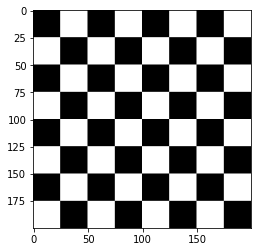

Vertical Edges


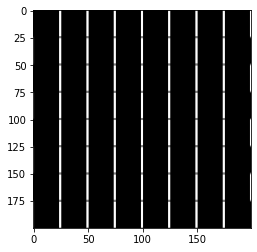

In [5]:
# TODO - define a function that computes the image derivatives along the horizontal axis
'''
def sobel_vertical_edges(image):
  # initialize the kernel/filter
  kernel_x = torch.tensor(...)
  # apply the kernel over the image 
  edges_x = ...
  return edges_x
'''
# Solution
def sobel_vertical_edges(image):
  kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  edges_x = convolution_with_padding(image, kernel_x, 1)
  return edges_x

synthetic_image_path = 'chessboard.png'
transf = transforms.ToTensor()
image = transf(Image.open(synthetic_image_path).convert(mode='L'))[0]
edges_x = sobel_vertical_edges(image)

print('Original Image')
plt.imshow(image, cmap='gray')
plt.show()
print('Vertical Edges')
plt.imshow(abs(edges_x), cmap='gray')

**Question 3** How do you explain the vertical edges detected in the rightmost part of the image? 

**Question 4** Can we avoid them?

Solution

**Answer 3** They are generated by the process of 0 padding the image. 

**Answer 4** Yes, we can use the 'replicate' mode for padding. 




**Estimate horizontal edges**
In order to estimate the horizontal edges, we need to define a second filter to be convolved over the image such that the convolution result approximates the image derivatives along the vertical dimension. 


Original Image


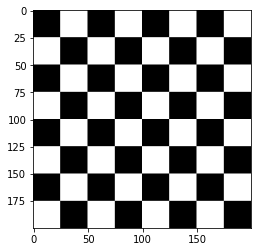

Horizontal Edges


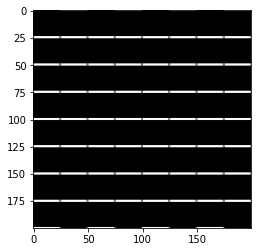

In [6]:
# TODO - define a function that computes the image derivatives along the vertical axis
'''
def sobel_horizontal_edges(image):
  ...
  return edges_y
'''
# Solution 
def sobel_horizontal_edges(image):
  kernel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  edges_y = convolution_with_padding(image, kernel_y, 1)
  return edges_y

edges_y = sobel_horizontal_edges(image)

print('Original Image')
plt.imshow(image, cmap='gray')
plt.show()
print('Horizontal Edges')
plt.imshow(abs(edges_y), cmap='gray')

**Edges Map**

Using the horizontal and vertical edges, we can compute the final edges map. 
Let $G_x$ be the vertical edges and  $G_y$ the horizontal ones. 

The gradient magnitude can be computed as follows:
$G = \sqrt{G_x^2+G_y^2}$

Original Image


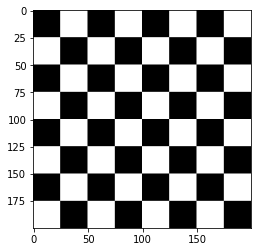

Edges


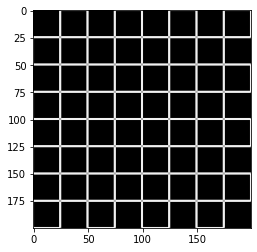

In [7]:
# TODO - define a function that given an input image, estimates the edges map
# the function will return the edges map along with the maps corresponding to vertical and horizontal edges
'''
def sobel_edges(image):
  ...
  return edges, edges_x, edges_y
'''
# Solution
def sobel_edges(image):
  edges_x = sobel_vertical_edges(image)
  edges_y = sobel_horizontal_edges(image)
  edges = torch.sqrt(torch.pow(edges_x,2)+torch.pow(edges_y,2))
  return edges, edges_x, edges_y

edges, _, _ = sobel_edges(image)

print('Original Image')
plt.imshow(image, cmap='gray')
plt.show()
print('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

Original Image


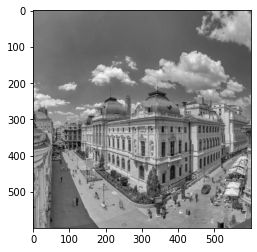

Vertical Edges


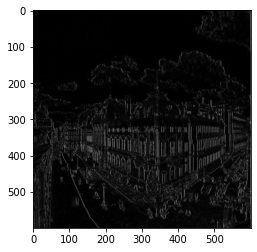

Horizontal Edges


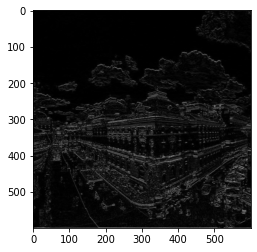

Edges


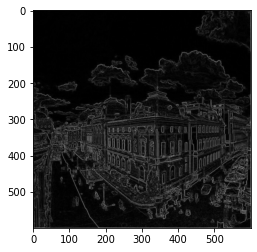

In [8]:
# now, let's apply the edge detector over a real image 
real_image_path = 'city.png'
transf = transforms.ToTensor()
image = transf(Image.open(real_image_path).convert(mode='L'))[0]

edges, edges_x, edges_y = sobel_edges(image)
print('Original Image')
plt.imshow(image, cmap='gray')
plt.show()
print('Vertical Edges')
plt.imshow(abs(edges_x), cmap='gray')
plt.show()
print('Horizontal Edges')
plt.imshow(abs(edges_y), cmap='gray')
plt.show()
print('Edges')
plt.imshow(edges, cmap='gray')
plt.show()

## 2D convolutions over multi-channel data








We will illustrate convolutions over three-channel images (RGB images):
<div>
<img src=https://drive.google.com/uc?id=1MZ64Ay5PIozenvyIzN1TveNEj-ATqnLd width="600"/>
<div>

The operations can be extrapolated to higher numbers of channels.

<div>
<img src=https://drive.google.com/uc?id=1Vu2CCnsmH7EGR5_nTDfh7ygOXnIP83CG width="600"/>
<div>

*Image Source: [link](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)*

Note: we will make use of the already implemented functions, and in the next section we will learn how to efficiently use the PyTorch implementation for implementing convolutions. 

### Application: compute Grayscale Images



Let $R$, $G$ and $B$ be the red, green and blue channels of an image. 

We will consider the weighted method for computing the grayscale representation of the image, as follows:

$grayscale = 0.299 R + 0.587 G + 0.114 B$

torch.Size([3, 1, 1])
Original Image


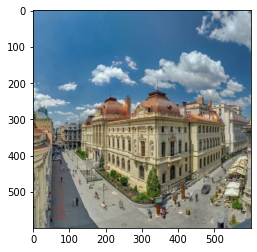

Grayscale Image


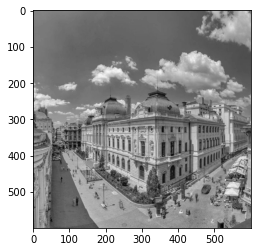

In [9]:
# TODO - we will implement the color conversion using convolution operations 
# Note: this is a highly ineficient approach and is used solely for exemplification
'''
def rgb_2_grayscale(image):
  # define the kernel
  kernel = ...
  # compute the grayscale image 
  grayscale = convolution(...)+convolution(...)+convolution(...)
  return grayscale
'''

# Solution
def rgb_2_grayscale(image):
  # define the kernel
  kernel = torch.tensor([[[0.299]], [[0.587]], [[0.114]]]) 
  print(kernel.shape)
  # compute the grayscale image 
  grayscale = convolution(image[0], kernel[0]) + convolution(image[1], kernel[1]) + convolution(image[2], kernel[2])
  return grayscale


image_path = 'city.png'
transf = transforms.ToTensor()
image = transf(Image.open(image_path))

grayscale = rgb_2_grayscale(image)

print('Original Image')
plt.imshow(image.permute(1,2,0))
plt.show()
print('Grayscale Image')
plt.imshow(grayscale, cmap='gray')
plt.show()

### Application: compute Blurred Grayscale Images


What if we also want to compute the blurred version of the image. So, we receive an RGB image and want to apply a convolution that returns us the blurred grayscale version of the image. 

In order to blur an image, we can simply perform an average of pixels in a local neighborhood. 

E.g. the following kernel can perform a blur over a $3\times 3$ neighborhood

$\begin{bmatrix}\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\ \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \end{bmatrix}$

torch.Size([3, 5, 5])
Original Image


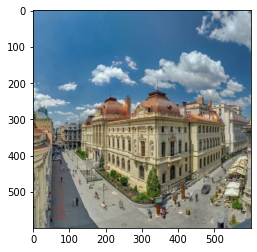

Blurred Grayscale Image


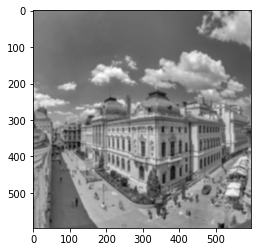

Grayscale Image


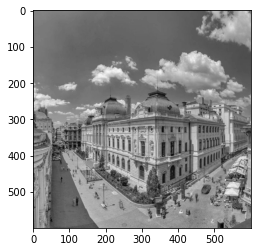

In [10]:
# TODO - implement the blur & grayscale conversion using convolution operations 
# Note: this is a highly ineficient approach and is used solely for exemplification
'''
def rgb_2_blurred_grayscale(image):
  # define the kernel that will perform the conversion
  kernel_r = torch.ones((5,5))* (1/25) * 0.299
  kernel_g = ... 
  kernel_b = ... 
  kernel = torch.cat(...) 
  # compute the result 
  blurred_grayscale = convolution(...)+convolution(...)+convolution(...)
  return blurred_grayscale
'''
# Solution
def rgb_2_blurred_grayscale(image):
  # define the kernel that will perform the conversion
  kernel_r = torch.ones((5,5))* (1/25) * 0.299
  kernel_g = torch.ones((5,5))* (1/25) * 0.587
  kernel_b = torch.ones((5,5))* (1/25) * 0.114
  kernel = torch.cat((kernel_r[None,:,:], kernel_g[None,:,:], kernel_b[None, :,:]), 0)
  print(kernel.shape)
  # compute the result 
  blurred_grayscale = convolution(image[0], kernel[0]) + convolution(image[1], kernel[1]) + convolution(image[2], kernel[2])
  return blurred_grayscale



image_path = 'city.png'
transf = transforms.ToTensor()
image = transf(Image.open(image_path))

blurred_grayscale = rgb_2_blurred_grayscale(image)

print('Original Image')
plt.imshow(image.permute(1,2,0))
plt.show()
print('Blurred Grayscale Image')
plt.imshow(blurred_grayscale, cmap='gray')
plt.show()
print('Grayscale Image')
plt.imshow(grayscale, cmap='gray')
plt.show()

# <font color='ED1F24'>Part II: CNN Layers  



<div>
<img src=https://drive.google.com/uc?id=1PtO6mNFtm71ftrn2ea0huyvEk9PpmXSd width="750"/>
<div>

*Image Source: [FloydHub](https://blog.floydhub.com/building-your-first-convnet/)*

##Convolution Layer



[torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - applies a 2D convolution over a single / multi-channel input signal


<div>
<img src=https://drive.google.com/uc?id=1BvNJZQqLIBHZC7d5Ojix8orIOYQ9fbSl width="1000"/>
<div>

Input size: $(N, C_{in}, H_{in}, W_{in})$

Output size: $(N, C_{out}, H_{out}, W_{out})$

$N$ - batch size / number of examples

$(H_{in},W_{in})$  - input size

$(H_{out},W_{out})$  - output size

$C_{in}$ - number of input channels (e.g. 3 for RGB images)

$C_{out}$ - number of output channels ( the number of filters)

The output of the layer:

$out(N_i, {C_{out}}_{j})=bias({C_{out}}_{j}) + \sum_{k=0}^{C_{in}-1}weight({C_{out}}_{j}, k)\ast input(N_i, k)$

**Stride** - defines the kernel shift 
<div>
<img src=https://drive.google.com/uc?id=18yxT_b-cJvZAwxi1FrssToqmOJyzfvPC width="200"/>
<div>

*Image Source: [GitHub](https://github.com/vdumoulin/conv_arithmetic)*

**Dilation**

<div>
<img src=https://drive.google.com/uc?id=1abJdd9TECdpoImtWW8MSxzioa-50znHB width="200"/>
<div>

*Image Source: [GitHub](https://github.com/vdumoulin/conv_arithmetic)*

**Groups**

<div>
<img src=https://drive.google.com/uc?id=1CuK7nOzuFgOdhBDf723PKQcrz1Hkr-gV width="1000"/>
<div>

*Image Source: [link](https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215)*

Now, let's play with a few convolutions

In [11]:
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)

torch.Size([1, 1, 3, 3])
Parameter containing:
tensor([[[[-0.2002,  0.0941,  0.2735],
          [-0.2714,  0.2701,  0.3157],
          [ 0.1073,  0.1234, -0.1099]]]], requires_grad=True)
torch.Size([1])
Parameter containing:
tensor([0.0870], requires_grad=True)


In [12]:
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,5))
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)

torch.Size([1, 1, 3, 5])
Parameter containing:
tensor([[[[ 0.1437, -0.1788,  0.1127,  0.1575, -0.1377],
          [-0.1335, -0.1235,  0.0705,  0.2141, -0.0179],
          [-0.1790,  0.2098,  0.2346, -0.0094,  0.1995]]]], requires_grad=True)
torch.Size([1])
Parameter containing:
tensor([0.0427], requires_grad=True)


In [13]:
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3,3))
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)

torch.Size([1, 3, 3, 3])
Parameter containing:
tensor([[[[-0.1025,  0.0349,  0.1468],
          [ 0.0758, -0.0049,  0.1566],
          [-0.1260,  0.0866,  0.1119]],

         [[ 0.1655,  0.0790, -0.0327],
          [-0.0693,  0.0720,  0.0771],
          [-0.0314,  0.0220,  0.1128]],

         [[-0.1210,  0.0173,  0.0359],
          [ 0.0710,  0.1407, -0.1588],
          [-0.0646, -0.0548, -0.0872]]]], requires_grad=True)
torch.Size([1])
Parameter containing:
tensor([0.1413], requires_grad=True)


In [14]:
# Try running the following configuration 
# Is everything working fine? Can you explain why?
'''
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=1, kernel_size=(3,5), groups=3)
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)
'''
# Solution - change the number of output channels 
# The above code is raising an error, as the number of output channels is not divisible by the number of groups. Each group should generate its own set of output channels. 
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,5), groups=3)
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)

torch.Size([3, 1, 3, 5])
Parameter containing:
tensor([[[[-0.0375, -0.1384,  0.1029,  0.1761, -0.2032],
          [ 0.1989, -0.0732,  0.0474,  0.0574,  0.1833],
          [ 0.2504,  0.0737,  0.1709, -0.1506, -0.1683]]],


        [[[ 0.0576,  0.1320,  0.2107,  0.0808, -0.0121],
          [ 0.0265,  0.1131,  0.0922, -0.2473,  0.2399],
          [ 0.0251, -0.1308,  0.0927,  0.1524, -0.1987]]],


        [[[ 0.0935, -0.1914, -0.0783,  0.2188,  0.0405],
          [-0.1294,  0.1147, -0.1529,  0.1103,  0.1958],
          [ 0.1832, -0.1234, -0.2114,  0.1117,  0.2331]]]], requires_grad=True)
torch.Size([3])
Parameter containing:
tensor([ 0.0829,  0.1066, -0.1340], requires_grad=True)


In [15]:
# We can drop the bias term
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(3,5), groups=3, bias=False)
print(conv_layer.weight.shape)
print(conv_layer.weight) 
print(conv_layer.bias.shape)
print(conv_layer.bias)
# note we will receive an error as there si no bias 

torch.Size([3, 1, 3, 5])
Parameter containing:
tensor([[[[-0.1223,  0.0125, -0.2283, -0.2042, -0.1473],
          [-0.0496,  0.0191, -0.2066, -0.2380,  0.1401],
          [-0.1767, -0.1781,  0.0096,  0.1252, -0.1331]]],


        [[[-0.1258,  0.0631, -0.1242,  0.1753,  0.0465],
          [-0.0148, -0.1650,  0.1267, -0.2233,  0.1658],
          [-0.0919, -0.1970, -0.2392,  0.0306,  0.1829]]],


        [[[ 0.0044, -0.0854,  0.2381, -0.0133, -0.0408],
          [ 0.1704,  0.1445,  0.0802,  0.1674, -0.0699],
          [ 0.1259, -0.2220,  0.2138,  0.0671,  0.1747]]]], requires_grad=True)


AttributeError: ignored

### Edge detection


Use torch.nn.Conv2d to implement the edge detector

torch.Size([3, 3])
Original Image


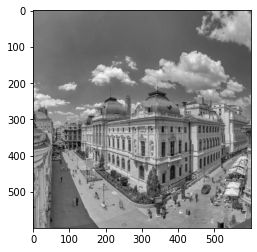

Vertical Edges


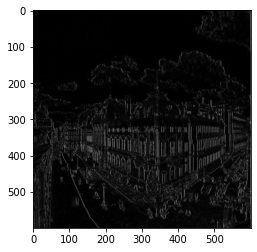

Horizontal Edges


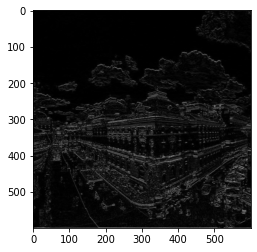

Edges


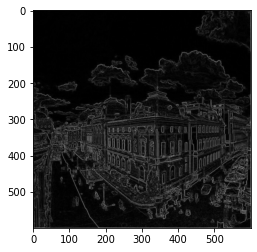

In [16]:
def sobel_edges_with_conv2d(image):
  # define the horizontal edges kernel
  sobel_horizontal_kernel = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
  # define the vertical edges kernel
  sobel_vertical_kernel = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)

  kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  print(kernel_x.shape)
  with torch.no_grad():
    sobel_vertical_kernel.weight.data.copy_(kernel_x)
    sobel_horizontal_kernel.weight.data.copy_(kernel_y)
  
  # note that the conv2d layer receives a batch of N images (N x C x H x W)
  edges_x = sobel_vertical_kernel(image[None,None,:,:]).squeeze().detach()
  edges_y = sobel_horizontal_kernel(image[None,None,:,:]).squeeze().detach()
  edges = torch.sqrt(torch.pow(edges_x,2)+torch.pow(edges_y,2))
  return edges, edges_x, edges_y
  
real_image_path = 'city.png'
transf = transforms.ToTensor()
image = transf(Image.open(real_image_path).convert(mode='L'))[0]

edges, edges_x, edges_y = sobel_edges_with_conv2d(image)

print('Original Image')
plt.imshow(image, cmap='gray')
plt.show()
print('Vertical Edges')
plt.imshow(abs(edges_x), cmap='gray')
plt.show()
print('Horizontal Edges')
plt.imshow(abs(edges_y), cmap='gray')
plt.show()
print('Edges')
plt.imshow(edges, cmap='gray')
plt.show()


## Pooling Layer



<div>
<img src=https://drive.google.com/uc?id=1a8mTuEPXVXpcTnV08V3PjOIh7AYTlTme width="400"/>
<div>

*Image Source: [link](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)*

### Max Pooling





[torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)

<div>
<img src=https://drive.google.com/uc?id=1uInwM4lPwuda5i_yxggSMYL9aLFhMJGi width="1000"/>
<div>

In [17]:
x = torch.rand((4,4))
print(x)
maxpool_layer = torch.nn.MaxPool2d(kernel_size=2)
x = x.unsqueeze(0).unsqueeze(0)
x = maxpool_layer(x)
print(x)

tensor([[0.3909, 0.2267, 0.2841, 0.8573],
        [0.8414, 0.7173, 0.6365, 0.6341],
        [0.3222, 0.3950, 0.4714, 0.9400],
        [0.6810, 0.9429, 0.0515, 0.2046]])
tensor([[[[0.8414, 0.8573],
          [0.9429, 0.9400]]]])


### Average Pooling



[torch.nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)

<div>
<img src=https://drive.google.com/uc?id=1fs2PhzwTIKZe9WHtP1nJ-tTLR5sD5bHC width="1000"/>
<div>


In [18]:
x = torch.rand((4,4))
print(x)
avgpool_layer = torch.nn.AvgPool2d(kernel_size=2)
x = x.unsqueeze(0).unsqueeze(0)
x = avgpool_layer(x)
print(x)

tensor([[0.1375, 0.7578, 0.1226, 0.2112],
        [0.7814, 0.9129, 0.6558, 0.8294],
        [0.7584, 0.6915, 0.1051, 0.3422],
        [0.4318, 0.9696, 0.4012, 0.3264]])
tensor([[[[0.6474, 0.4547],
          [0.7128, 0.2937]]]])


# <font color='ED1F24'> Part III: CNNs for Image Classification

## MNIST Dataset








For this section we will use [The MNIST Database](http://yann.lecun.com/exdb/mnist/).


*   handwritten digits
*   size-normalized and centered in a fixed-size image ($28 \times 28$)

*   training set - 60 000 examples 
*   test set - 10 000 examples 

In [19]:
# download the MNIST dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-03-22 15:15:18--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-03-22 15:15:18--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [                 <=>]  33.20M  8.45MB/s    in 3.9s    

2023-03-22 15:15:23 (8.45 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

torch.Size([64, 1, 28, 28])
torch.Size([64])
Labels of the shown images: tensor([6, 5, 5, 9, 6])


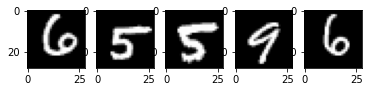

In [20]:
# we create a loader to iterate through the dataset
# https://pytorch.org/vision/stable/datasets.html
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True,drop_last=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=False,drop_last=True)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_dataloader))
print(first_train_batch_imgs.shape)
print(first_train_batch_labels.shape)

f, axarr = plt.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0], cmap='gray')
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')

## Image Classification with a Fully Connected Network

We will try to solve the problem with a fully connected network first.





In [21]:
class FCNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=1*28*28, out_features=500)
        self.output_layer = nn.Linear(in_features=500, out_features = 10)
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # flatten the images
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.layer_1(x))
        x = self.output_layer(x)
        return x

In [22]:
torch.manual_seed(115)
fcnn_model = FCNNClassifier()

num_params = 0
print("Model's parameters: ")
for n, p in fcnn_model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 layer_1.weight :  torch.Size([500, 784])
	 layer_1.bias :  torch.Size([500])
	 output_layer.weight :  torch.Size([10, 500])
	 output_layer.bias :  torch.Size([10])
Number of model parameters:  397510


**Question 5** Is there a potential issue inside the forward function? 

Solution

**Answer 5** We may receive a non-contiguous tensor, resulting in a crash when calling 'view'.

In [23]:
x = torch.rand((28,28)).unsqueeze(0).unsqueeze(0)
print(x.shape)
print(fcnn_model(x))

torch.Size([1, 1, 28, 28])
tensor([[ 0.2022, -0.0455, -0.0712, -0.0081, -0.1413,  0.0858, -0.2222, -0.1446,
         -0.0128, -0.1385]], grad_fn=<AddmmBackward0>)


In [24]:
x = torch.rand((30,30))
x = x[2:30, 2:30].unsqueeze(0).unsqueeze(0)
print(x.shape)
print(fcnn_model(x))

torch.Size([1, 1, 28, 28])


RuntimeError: ignored

In [25]:
x = torch.rand((30,30))
x = x[2:30, 2:30].unsqueeze(0).unsqueeze(0)
print(x.shape)
x=x.contiguous()
print(fcnn_model(x))

torch.Size([1, 1, 28, 28])
tensor([[ 0.1047, -0.0095, -0.1020,  0.0369, -0.0396,  0.0617, -0.0336, -0.1632,
         -0.0522, -0.0583]], grad_fn=<AddmmBackward0>)


We will define the training and validation loops.

In [26]:
def train_epoch(model, train_dataloader, loss_crt, optimizer, device):
    """
    model: Model object 
    train_dataloader: DataLoader over the training dataset
    loss_crt: loss function object
    optimizer: Optimizer object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch training loss, which is an average over the individual batch
       losses
    """
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(train_dataloader)
    
    for batch_idx, batch in tqdm(enumerate(train_dataloader)):
        # shape: batch_size x 1 x 28 x 28, batch_size x 1
        batch_img, batch_labels = batch
        
        # move data to GPU
        batch_img = batch_img.to(device)
        batch_labels = batch_labels.to(device)
        
        # initialize as zeros all the gradients of the model
        model.zero_grad()

        # get predictions from the FORWARD pass 
        # shape: batch_size x 10
        output = model(batch_img)

        loss = loss_crt(output, batch_labels.squeeze())       
        loss_scalar = loss.item()

        # BACKPROPAGATE the gradients
        loss.backward()
        # use the gradients to OPTIMISE the model
        optimizer.step()
        
        epoch_loss += loss_scalar

        pred = output.argmax(dim=1, keepdim=True)
        epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()
        
    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object 
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns: 
     - the epoch validation loss, which is an average over the individual batch
       losses
    """
    model.eval()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = len(val_dataloader)
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(val_dataloader)):
            # shape: batch_size x 3 x 28 x 28, batch_size x 1
            batch_img, batch_labels = batch
            current_batch_size = batch_img.size(0)

            # move data to GPU
            batch_img = batch_img.to(device)
            batch_labels = batch_labels.to(device)
 
            # batch_size x 10
            output = model(batch_img)

            loss = loss_crt(output, batch_labels.squeeze())
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

            pred = output.argmax(dim=1, keepdim=True)
            epoch_accuracy += pred.eq(batch_labels.view_as(pred)).float().mean().item()

    epoch_loss = epoch_loss/num_batches
    epoch_accuracy = 100. * epoch_accuracy/num_batches
    return epoch_loss, epoch_accuracy

In [27]:
# move the model to GPU (when available)
fcnn_model.to(device)

# create a SGD optimizer
optimizer = torch.optim.SGD(fcnn_model.parameters(), lr=0.01, momentum=0.9)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(fcnn_model, train_dataloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(fcnn_model, test_dataloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))


937it [00:11, 79.31it/s]
156it [00:01, 105.87it/s]



Epoch 1
train loss: 0.44426448, accuracy: 88.27207844
val loss: 0.24354530, accuracy: 92.90865385


937it [00:08, 112.63it/s]
156it [00:01, 86.37it/s]



Epoch 2
train loss: 0.21566641, accuracy: 93.87506670
val loss: 0.18033762, accuracy: 94.66145833


937it [00:08, 104.66it/s]
156it [00:01, 113.67it/s]



Epoch 3
train loss: 0.15931429, accuracy: 95.51260672
val loss: 0.13666605, accuracy: 96.13381410


937it [00:09, 103.07it/s]
156it [00:01, 125.78it/s]



Epoch 4
train loss: 0.12532005, accuracy: 96.42475987
val loss: 0.11294340, accuracy: 96.73477564


937it [00:09, 103.01it/s]
156it [00:01, 120.64it/s]



Epoch 5
train loss: 0.10267116, accuracy: 97.13513874
val loss: 0.10068106, accuracy: 97.00520833


937it [00:08, 114.66it/s]
156it [00:01, 84.10it/s]



Epoch 6
train loss: 0.08641697, accuracy: 97.61706243
val loss: 0.09166981, accuracy: 97.19551282


937it [00:08, 109.04it/s]
156it [00:01, 126.14it/s]



Epoch 7
train loss: 0.07447460, accuracy: 97.93389808
val loss: 0.08355577, accuracy: 97.45592949


937it [00:09, 103.34it/s]
156it [00:01, 125.51it/s]



Epoch 8
train loss: 0.06486817, accuracy: 98.23405816
val loss: 0.07987505, accuracy: 97.70633013


937it [00:09, 102.21it/s]
156it [00:01, 121.07it/s]



Epoch 9
train loss: 0.05792627, accuracy: 98.42582711
val loss: 0.07505094, accuracy: 97.72636218


937it [00:08, 112.05it/s]
156it [00:01, 88.77it/s]


Epoch 10
train loss: 0.05127809, accuracy: 98.65094717
val loss: 0.07270762, accuracy: 97.78645833


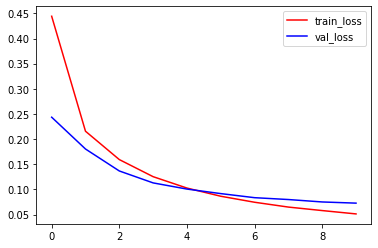

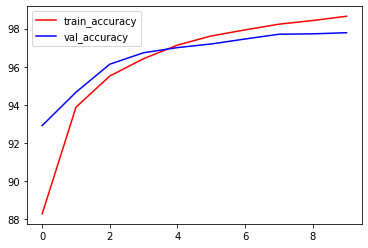

In [28]:
# plot loss & accuracy
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.plot(val_losses, label='val_loss', color='blue')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train_accuracy', color='red')
plt.plot(val_accuracies, label='val_accuracy', color='blue')
plt.legend()
plt.show()


## Image Classification with a Convolutional Neural Network





Now, we will solve the same classification problem using a CNN model. 

The architecture:

*   Conv Layer: 20 filters, kernel size: 5x5, stride: 1
*   ReLU
*   Max Pool Layer: kernel size: 2x2, stride: 2
*   Conv Layer: 50 filters, kernel size: 5x5, stride:1
*   ReLU 
*   Max Pool Layer: kernel size: 2x2, stride: 2
*   Fully Connected Layer: 500 neurons
*   ReLU
*   Fully Connected Layer: 10 neurons 

In [29]:
# implement the above architecture 
'''
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(...)
        self.conv2 = nn.Conv2d(...)
        # note that the maps are flattened before this layer
        # you need to infer the input size of the fully connected layer
        self.fc1 = nn.Linear(...)
        self.fc2 = nn.Linear(...)
        self.activation_fn = ...
        self.pool = nn.MaxPool2d(...)

    def forward(self, x):
        x = ...
        return x
'''

# Solution
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = 5, stride = 1)
        self.fc1 = nn.Linear(in_features = 4 * 4 * 50, out_features = 500)
        self.fc2 = nn.Linear(in_features = 500, out_features = 10)
        self.activation_fn = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x = ...
        x = self.activation_fn(self.conv1(x))
        x = self.pool(x)
        x = self.activation_fn(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.shape[0], -1)
        x = self.activation_fn(self.fc1(x))
        x = self.fc2(x)
        return x 


In [31]:
torch.manual_seed(115)
cnn_model = CNNClassifier()

num_params = 0
print("Model's parameters: ")
for n, p in cnn_model.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 conv1.weight :  torch.Size([20, 1, 5, 5])
	 conv1.bias :  torch.Size([20])
	 conv2.weight :  torch.Size([50, 20, 5, 5])
	 conv2.bias :  torch.Size([50])
	 fc1.weight :  torch.Size([500, 800])
	 fc1.bias :  torch.Size([500])
	 fc2.weight :  torch.Size([10, 500])
	 fc2.bias :  torch.Size([10])
Number of model parameters:  431080


In [32]:
# move the model to GPU (when available)
cnn_model.to(device)

# create a SGD optimizer
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(cnn_model, train_dataloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(cnn_model, test_dataloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

937it [00:13, 67.11it/s] 
156it [00:01, 86.42it/s]



Epoch 1
train loss: 0.29581994, accuracy: 91.19030149
val loss: 0.05840121, accuracy: 98.13701923


937it [00:09, 94.53it/s]
156it [00:01, 119.79it/s]



Epoch 2
train loss: 0.06139637, accuracy: 98.07230523
val loss: 0.04468939, accuracy: 98.54767628


937it [00:10, 90.06it/s]
156it [00:01, 117.36it/s]



Epoch 3
train loss: 0.04211552, accuracy: 98.69096852
val loss: 0.03159831, accuracy: 98.99839744


937it [00:10, 91.40it/s]
156it [00:01, 115.98it/s]



Epoch 4
train loss: 0.03209404, accuracy: 98.98279082
val loss: 0.03475195, accuracy: 98.82812500


937it [00:10, 90.56it/s] 
156it [00:01, 115.83it/s]



Epoch 5
train loss: 0.02542811, accuracy: 99.24126201
val loss: 0.02633833, accuracy: 99.17868590


937it [00:10, 91.20it/s]
156it [00:01, 118.41it/s]



Epoch 6
train loss: 0.02062065, accuracy: 99.34798559
val loss: 0.03065822, accuracy: 99.03846154


937it [00:10, 91.79it/s]
156it [00:01, 114.42it/s]



Epoch 7
train loss: 0.01651999, accuracy: 99.46971718
val loss: 0.02946772, accuracy: 99.03846154


937it [00:09, 97.50it/s]
156it [00:01, 79.14it/s]



Epoch 8
train loss: 0.01394134, accuracy: 99.55309498
val loss: 0.03019102, accuracy: 99.01842949


937it [00:09, 98.19it/s] 
156it [00:01, 111.48it/s]



Epoch 9
train loss: 0.01147438, accuracy: 99.64647812
val loss: 0.02493386, accuracy: 99.21875000


937it [00:10, 93.45it/s]
156it [00:01, 122.68it/s]


Epoch 10
train loss: 0.00956251, accuracy: 99.69983991
val loss: 0.03117837, accuracy: 99.06850962


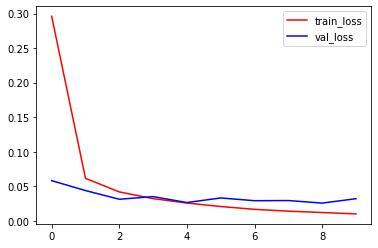

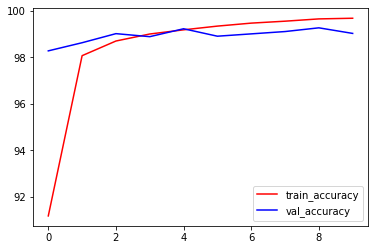

In [ ]:
# plot loss & accuracy
plt.figure()
plt.plot(train_losses, label='train_loss', color='red')
plt.plot(val_losses, label='val_loss', color='blue')
plt.legend()
plt.show()
plt.plot(train_accuracies, label='train_accuracy', color='red')
plt.plot(val_accuracies, label='val_accuracy', color='blue')
plt.legend()
plt.show()

# <font color='ED1F24'> Part IV: Transfer Learning 


<div>
<img src=https://drive.google.com/uc?id=1Lx_VHuOyjariEPPrB6iahV0_30mrXLB7 width="700"/>
<div>

**How**:


*   finetuning - start from the pretrained weights, but the whole model is retrained.
*   feature extraction - use the pretrained model solely for feature extraction and we train a classifier on top of those features.

In this laboratory we will implement the feature extraction approach.



## ResNet Architecture



<div>
<img src=https://drive.google.com/uc?id=1QX_AYUEYYzQcBLVGaRHfXj24ttmHFdHN width="1000"/>
<div>

*Image Source: He et al. Deep Residual Learning for Image Recognition [paper](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)*


Main advantages
*   train deeper models
*   easily optimise by allowing direct paths between lower and upper levels

More detailes regarding the ResNet architecture will be discussed in next laboratory and during the lectures. For the moment, we will treat it as a black box.

## Pretrained ResNet

Multiple model definitions along with their pretrained weights are available in the [torchvision.models](https://pytorch.org/vision/0.8/models.html). The models have been pretrained on the 1000-class ImageNet dataset.

The model inputs are mini-batches of 3-channel images of shape $(3\times height \times width)$. For many pretrained models, $height$ and $width$ are expected to be $224$.

The input images should be in range $[0,1]$, normalized using:

$mean=[0.485, 0.456, 0.406]$

$std=[0.229, 0.224, 0.225]$



In [34]:
import torchvision.models as models 
# load the ResNet-18 model, with randomly initialized weights 
resnet18_random = models.resnet18(weights=None)
# load the ResNet-18 model, with weights pretrained on ImageNet 
resnet18_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_params = 0
print("Model's parameters: ")
for n, p in resnet18_pretrained.named_parameters():
    print('\t', n, ': ', p.size())
    num_params += p.numel()
print("Number of model parameters: ", num_params)

Model's parameters: 
	 conv1.weight :  torch.Size([64, 3, 7, 7])
	 bn1.weight :  torch.Size([64])
	 bn1.bias :  torch.Size([64])
	 layer1.0.conv1.weight :  torch.Size([64, 64, 3, 3])
	 layer1.0.bn1.weight :  torch.Size([64])
	 layer1.0.bn1.bias :  torch.Size([64])
	 layer1.0.conv2.weight :  torch.Size([64, 64, 3, 3])
	 layer1.0.bn2.weight :  torch.Size([64])
	 layer1.0.bn2.bias :  torch.Size([64])
	 layer1.1.conv1.weight :  torch.Size([64, 64, 3, 3])
	 layer1.1.bn1.weight :  torch.Size([64])
	 layer1.1.bn1.bias :  torch.Size([64])
	 layer1.1.conv2.weight :  torch.Size([64, 64, 3, 3])
	 layer1.1.bn2.weight :  torch.Size([64])
	 layer1.1.bn2.bias :  torch.Size([64])
	 layer2.0.conv1.weight :  torch.Size([128, 64, 3, 3])
	 layer2.0.bn1.weight :  torch.Size([128])
	 layer2.0.bn1.bias :  torch.Size([128])
	 layer2.0.conv2.weight :  torch.Size([128, 128, 3, 3])
	 layer2.0.bn2.weight :  torch.Size([128])
	 layer2.0.bn2.bias :  torch.Size([128])
	 layer2.0.downsample.0.weight :  torch.Size([12

In [35]:
# TODO - apply the ResNet model over a randomly generated batch of one 224 x 224 image & check the output dimension 
# try different input dimensions - e.g. 100 and 28 
'''
...
'''
# Solution
image_batch = torch.rand((10, 3, 10, 10))
res = resnet18_pretrained(image_batch)
print(res.shape)

# the model is robust to different input dimensions, as there is an Adaptive Average Pooling layer before the linear layer
# yet, when the the size is too small, one conv layer will output a 1x1 map and since we are providing solely 1 example, it cannot compute the batch statistics for the batch norm layer 
# try moving the model in eval mode, or increase the batch size to validate the issue

torch.Size([10, 1000])


In [36]:
# TODO - apply the ResNet model over a real image, after resizing it to 224 x 224
# do not forget to apply the required transformations over the image
 
image_path = 'city.png'
# define transformations to be applied over the image
'''
transf = ...
image = ...
# apply ResNet
res = resnet18_pretrained(...)
print(res.shape)
'''

# Solution

image_path = 'city.png'
# define transformations to be applied over the image
transf = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])                         
  ])
image = transf(Image.open(image_path))
#resnet18_pretrained.eval()
res = resnet18_pretrained(image.unsqueeze(0))
print(res.shape)

torch.Size([1, 1000])


## Cats vs. Dogs Dataset





We will work on the Cats vs. Dogs Dataset introduced in Laboratory 3

*   classify images based on their content
*   images containing cats or dogs $⇒$ 2 classes
*   training set - 2000 examples 
*   test set - 1000 examples

In [37]:
import zipfile
import os

# Download the samples
!wget --no-check-certificate \
https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
-O /tmp/cats_and_dogs_filtered.zip

# Extract the data
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# set up train and validation dirs
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2023-03-22 15:53:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.3MB/s    in 4.0s    

2023-03-22 15:53:44 (16.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [39]:
class CatsAndDogsDataset(Dataset):
  def __init__(self, data_dir: str, transform=None):
    # dir structure:
    # /
    #  /cats/
    #        cat.0.jpg
    #        cat.1.jpg
    #        ...
    #  /dogs/
    #        dog.0.jpg  
    #        dog.1.jpg
    #        ...           
    #  
    self.data_dir = data_dir

    # directory containing cat pictures
    self.cats_dir = os.path.join(self.data_dir, 'cats')

    # directory containing dog pictures
    self.dogs_dir = os.path.join(self.data_dir, 'dogs')

    self.cat_fnames = [os.path.join(self.cats_dir, fname) \
                        for fname in os.listdir(self.cats_dir)]
    self.dog_fnames = [os.path.join(self.dogs_dir, fname) \
                        for fname in os.listdir(self.dogs_dir)]

    self.fnames = self.cat_fnames + self.dog_fnames

    self.labels = len(self.cat_fnames) * [0] + len(self.dog_fnames) * [1]

    # TODO - implement the transformations 
    #      - resize images to 224 x 224 
    #      - normalize images 
    '''
    self.image_transforms = ...
    '''
    
    # Solution
    self.image_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
    ])

  def __getitem__(self, index):
    fname = self.fnames[index]
    img_obj = Image.open(fname)
    img_tensor = self.image_transforms(img_obj)
    
    # retrieve the image's label and store it into a Tensor
    label = self.labels[index]
    label_tensor = torch.tensor([label])

    return img_tensor, label_tensor
  
  def __len__(self):
    return len(self.fnames)

torch.Size([64, 3, 224, 224])
torch.Size([64, 1])
Labels of the shown images: tensor([[0],
        [0],
        [1],
        [1],
        [1]])


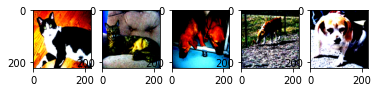

In [40]:
# get train & validation datasets 
train_dataset = CatsAndDogsDataset(data_dir=train_dir)
validation_dataset = CatsAndDogsDataset(data_dir=validation_dir)
# instantiate the dataloaders
batch_size = 64
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size
)

# visualize few examples
train_batch_imgs, train_batch_labels = next(iter(train_dataloader))
print(train_batch_imgs.shape)
print(train_batch_labels.shape)

f, axarr = plt.subplots(1,5)
for i in range(5):
  axarr[i].imshow(train_batch_imgs[i].permute(1,2,0))
print(f'Labels of the shown images: {train_batch_labels[:5]}')

Labels of the shown images: tensor([[0],
        [0],
        [1],
        [1],
        [1]])


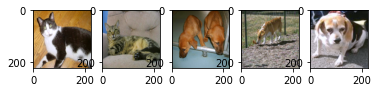

In [41]:
inv_transforms = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
          std=[1/0.229, 1/0.224, 1/0.255])
    ])
train_batch_imgs = inv_transforms(train_batch_imgs)

f, axarr = plt.subplots(1,5)
for i in range(5):
  axarr[i].imshow(train_batch_imgs[i].permute(1,2,0))
print(f'Labels of the shown images: {train_batch_labels[:5]}')

## Feature extraction

We use the pretrained model solely for feature extraction and we train a classifier on top of those features.

In [42]:
# function counting the number of parameters and the number of trainable parameters of a model 
# optionally, it will also display the layers
def check_model_parameters(model, display_layers=False):
  num_params = 0
  num_trainable_params = 0
  if display_layers==True:
    print("Model's parameters: ")
  for n, p in model.named_parameters():
      if display_layers == True:
        print('\t', n, ': ', p.size())
      num_params += p.numel()
      if p.requires_grad:
        num_trainable_params += p.numel()
  print("Number of model parameters: ", num_params)
  print("Number of trainable parameters: ", num_trainable_params)

In [43]:
# freeze the model parameters 
import torchvision.models as models 
# load the ResNet-18 model, with weights pretrained on ImageNet 
resnet18_pretrained = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# check the number of parameters and the number of trainable parameters
check_model_parameters(resnet18_pretrained, display_layers=False)

# freeze all the layers
for param in resnet18_pretrained.parameters():
  param.requires_grad = False 

# check the number of parameters and the number of trainable parameters
check_model_parameters(resnet18_pretrained, display_layers=False)


Number of model parameters:  11689512
Number of trainable parameters:  11689512
Number of model parameters:  11689512
Number of trainable parameters:  0


In [44]:
torch.manual_seed(115)
# TODO - change the last layer of the model to adapt it for our task
# Hint - look at the layers of the model, you need to change the last one s.t. the number of output classes is 2, instead of 1000
#      - this last layer is a simple linear layer
'''
...
'''
# Solution
resnet18_pretrained.fc = nn.Linear(in_features=512, out_features=2, bias=True)

check_model_parameters(resnet18_pretrained, display_layers=True)

Model's parameters: 
	 conv1.weight :  torch.Size([64, 3, 7, 7])
	 bn1.weight :  torch.Size([64])
	 bn1.bias :  torch.Size([64])
	 layer1.0.conv1.weight :  torch.Size([64, 64, 3, 3])
	 layer1.0.bn1.weight :  torch.Size([64])
	 layer1.0.bn1.bias :  torch.Size([64])
	 layer1.0.conv2.weight :  torch.Size([64, 64, 3, 3])
	 layer1.0.bn2.weight :  torch.Size([64])
	 layer1.0.bn2.bias :  torch.Size([64])
	 layer1.1.conv1.weight :  torch.Size([64, 64, 3, 3])
	 layer1.1.bn1.weight :  torch.Size([64])
	 layer1.1.bn1.bias :  torch.Size([64])
	 layer1.1.conv2.weight :  torch.Size([64, 64, 3, 3])
	 layer1.1.bn2.weight :  torch.Size([64])
	 layer1.1.bn2.bias :  torch.Size([64])
	 layer2.0.conv1.weight :  torch.Size([128, 64, 3, 3])
	 layer2.0.bn1.weight :  torch.Size([128])
	 layer2.0.bn1.bias :  torch.Size([128])
	 layer2.0.conv2.weight :  torch.Size([128, 128, 3, 3])
	 layer2.0.bn2.weight :  torch.Size([128])
	 layer2.0.bn2.bias :  torch.Size([128])
	 layer2.0.downsample.0.weight :  torch.Size([12

In [45]:
resnet18_pretrained.to(device)

# create a SGD optimizer
optimizer = torch.optim.SGD(resnet18_pretrained.parameters(), lr=0.01, momentum=0.9)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

# evaluate the initial model 
val_loss, val_accuracy = eval_epoch(resnet18_pretrained, validation_dataloader, loss_criterion, device)
print('Validation performance before finetuning -- loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

# finetune the model 
num_epochs = 2
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(resnet18_pretrained, train_dataloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(resnet18_pretrained, validation_dataloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

16it [00:06,  2.42it/s]


Validation performance before finetuning -- loss: 1.04916619, accuracy: 48.53515625


32it [00:12,  2.49it/s]
16it [00:06,  2.55it/s]



Epoch 1
train loss: 0.22361422, accuracy: 89.30664062
val loss: 0.05913007, accuracy: 96.91406265


32it [00:12,  2.66it/s]
16it [00:06,  2.37it/s]


Epoch 2
train loss: 0.08597181, accuracy: 96.38671875
val loss: 0.10121712, accuracy: 95.99609375


In [ ]:
# TODO - train the resnet architecture from scratch and compare the obtained results 
#      - we will employ the same training strategy 
torch.manual_seed(115)
'''
...
'''

# Solution
# load the ResNet-18 model, with randomly initialized weights 
resnet18_random = models.resnet18(pretrained=False)
check_model_parameters(resnet18_random, display_layers=False)
resnet18_random.fc = nn.Linear(in_features=512, out_features=2, bias=True)
check_model_parameters(resnet18_random, display_layers=False)

resnet18_random.to(device)

# create a SGD optimizer
optimizer = torch.optim.SGD(resnet18_random.parameters(), lr=0.01, momentum=0.9)

# set up loss function
loss_criterion = nn.CrossEntropyLoss()

# evaluate the initial model 
val_loss, val_accuracy = eval_epoch(resnet18_random, validation_dataloader, loss_criterion, device)
print('Validation performance before training -- loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))


# finetune the model 
num_epochs = 2
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(1, num_epochs+1):
  train_loss, train_accuracy = train_epoch(resnet18_random, train_dataloader, loss_criterion, optimizer, device)
  val_loss, val_accuracy = eval_epoch(resnet18_random, validation_dataloader, loss_criterion, device)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)
  print('\nEpoch %d'%(epoch))
  print('train loss: %10.8f, accuracy: %10.8f'%(train_loss, train_accuracy))
  print('val loss: %10.8f, accuracy: %10.8f'%(val_loss, val_accuracy))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of model parameters:  11689512
Number of trainable parameters:  11689512
Number of model parameters:  11177538
Number of trainable parameters:  11177538


16it [00:05,  2.80it/s]


Validation performance before training -- loss: 0.85590271, accuracy: 51.17187500


32it [00:15,  2.11it/s]
16it [00:06,  2.39it/s]



Epoch 1
train loss: 0.70142327, accuracy: 56.00585938
val loss: 0.69993926, accuracy: 54.14062515


32it [00:15,  2.09it/s]
16it [00:05,  2.92it/s]


Epoch 2
train loss: 0.67502182, accuracy: 62.06054688
val loss: 0.67642247, accuracy: 60.60546897


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('/content/drive/MyDrive/Courses/FMI_2023/lab/Lab_5_(solutions)-2022.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y

'File Download Unsuccessful. Saved in Google Drive'